# 20뉴스그룹 데이터 전처리하기

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :', len(documents))

총 샘플 수 : 11314


In [3]:
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [4]:
news_df.isnull().values.any()

False

In [5]:
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [6]:
news_df.dropna(inplace=True)
print('총 샘플 수 :', len(news_df))

총 샘플 수 : 10995


In [7]:
# 불용어를 제거
import nltk
nltk.download('stopwords')

stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :', len(tokenized_doc))

총 샘플 수 : 10940


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [10]:
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [11]:
vocab_size = len(word2idx) + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


# 네거티브 샘플링을 통한 데이터셋 구성하기

In [12]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [13]:
# 첫번째 샘플인 skip_gram[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}, {:s} ({:d})) -> {:d}".format(
        idx2word[pairs[i][0]], pairs[i][0],
        idx2word[pairs[i][1]], pairs[i][1],
        labels[i]))

(might (52, pohlig (62530)) -> 0
(ignore (1979, europe (1095)) -> 1
(europeans (4520, emcon (28887)) -> 0
(shame (4988, soldiers (957)) -> 1
(clearly (661, cweventmask (61604)) -> 0


In [14]:
print('전체 샘플 수 :', len(skip_grams))

전체 샘플 수 : 10


In [15]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2220
2220


In [16]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

# Skip-Gram with Negative Sampling(SGNS) 구현하기

In [17]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [18]:
embedding_dim = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')

context_embedding = Embedding(vocab_size, embedding_dim)(c_inputs)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       6427700     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       6427700     ['input_2[0][0]']                
                                                                                              

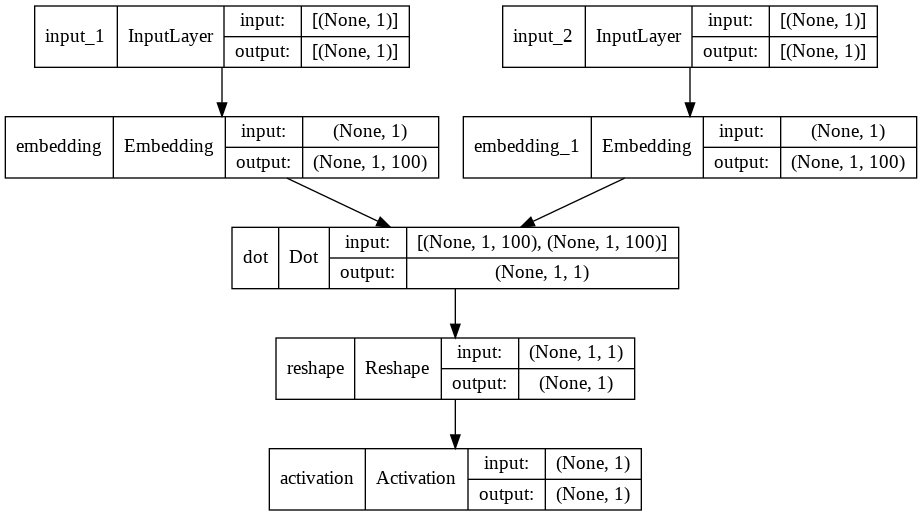

In [19]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs = [w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [20]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)
    print('Epoch :', epoch, 'Loss :', loss)

Epoch : 1 Loss : 4630.394626125693
Epoch : 2 Loss : 3677.16629082337
Epoch : 3 Loss : 3519.4167666379362
Epoch : 4 Loss : 3313.8339303899556
Epoch : 5 Loss : 3090.4611124368384


# 결과 확인하기

In [22]:
import gensim

f = open('vectors.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embedding_dim))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [27]:
w2v.most_similar(positive=['soldiers'])

[('shelling', 0.836643636226654),
 ('wounded', 0.8343514204025269),
 ('baku', 0.8153501749038696),
 ('elderly', 0.7822454571723938),
 ('azerbaijanis', 0.7821229100227356),
 ('terrorist', 0.7793484926223755),
 ('massacred', 0.7788301706314087),
 ('villages', 0.7774794697761536),
 ('stalin', 0.7748045921325684),
 ('camps', 0.7739220857620239)]

In [28]:
w2v.most_similar(positive=['doctor'])

[('acute', 0.5851302742958069),
 ('tablets', 0.5378235578536987),
 ('clinic', 0.5348395705223083),
 ('infection', 0.5336679816246033),
 ('treatments', 0.5200117230415344),
 ('swollen', 0.5158957839012146),
 ('migraine', 0.5151313543319702),
 ('bacteria', 0.5116358995437622),
 ('diet', 0.5086444616317749),
 ('medication', 0.5069221258163452)]

In [29]:
w2v.most_similar(positive=['police'])

[('libertarians', 0.6889998912811279),
 ('regulation', 0.6485955715179443),
 ('filed', 0.6404256224632263),
 ('governments', 0.6226335763931274),
 ('enemy', 0.6155691742897034),
 ('officers', 0.6142174601554871),
 ('impose', 0.6136372089385986),
 ('iraq', 0.6043327450752258),
 ('defamation', 0.6021339297294617),
 ('cemetery', 0.5999908447265625)]

In [30]:
w2v.most_similar(positive=['knife'])

[('gentiles', 0.6883518099784851),
 ('baptism', 0.670666515827179),
 ('anger', 0.6624901294708252),
 ('nixon', 0.6623672246932983),
 ('israelites', 0.6622375249862671),
 ('abraham', 0.6603471040725708),
 ('demanded', 0.6598212718963623),
 ('minority', 0.6588810086250305),
 ('righteousness', 0.656692385673523),
 ('sinful', 0.6531589031219482)]

In [31]:
w2v.most_similar(positive=['engine'])

[('honda', 0.5409330129623413),
 ('injected', 0.5405776500701904),
 ('rebuilt', 0.5352831482887268),
 ('koni', 0.5259250402450562),
 ('barrel', 0.5243951678276062),
 ('strap', 0.519733190536499),
 ('valve', 0.5078797936439514),
 ('ground', 0.5014320015907288),
 ('brakes', 0.4982203245162964),
 ('torque', 0.4966503977775574)]